#  Accumulated Local Effects (ALE) Plots for Multi-Class

[Machine Learning Interpretability course](https://www.trainindata.com/p/machine-learning-interpretability)

This notebook was created by [Sal J.M](https://www.linkedin.com/in/salim-j-m-a04534114/). Thank you so much for your contribution Sal!!

 - In this notebook, our primary aim is to clarify the concept of Accumulated Local Effects (ALE) and its role in assessing the influence of features on a model in the context of a multi-class classification challenge.
 
 - We'll be computing ALE using the ALIBI Python package. Our focus will be on understanding how these effects can be quantified for each class within the target variable.
 
 - To illustrate this, we'll be using the familiar iris dataset.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [105]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [106]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

### Load Iris data

In [4]:
# Load the Iris dataset from scikit-learn
iris = load_iris()

# Create a pandas DataFrame from the Iris dataset
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)

# The target variable (species) is available as 'target' in iris
iris_df['species'] = iris.target

# Create X (features) and y (target)
X = iris_df.drop('species', axis=1)
y = iris_df['species']

In [5]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

- 0 corresponds to the species "setosa."
- 1 corresponds to the species "versicolor."
- 2 corresponds to the species "virginica."

### Split Data

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [7]:
X_train.shape, X_test.shape

((105, 4), (45, 4))

In [8]:
y_train.shape, y_test.shape

((105,), (45,))

In [9]:
y_test.value_counts()

2    15
1    15
0    15
Name: species, dtype: int64

### Train XGBOOST

In [11]:
# create xgboost classifier
xgbc = XGBClassifier(n_estimators=10,
                     max_depth=1,
                     random_state=3,)

# train
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [104]:
accuracy_score(y_test, xgbc.predict(X_test))

0.9333333333333333

### XGBoost Feature Importance

 XGboost provides feature importance which can be used as a gloabal interpretation method


In [12]:
pd.Series(xgbc.feature_importances_, index=X_train.columns).sort_values(ascending=False)

petal width (cm)     0.543876
petal length (cm)    0.456124
sepal length (cm)    0.000000
sepal width (cm)     0.000000
dtype: float32

### ALE with Alibi for the XGBoost model

 - To generate the ALE plots, follow these steps:
     - Import the ALE explainer module.
     - Import the plot_ale function.
     - Create an ALE instance to compute the ALE values.
     - Utilize the plot_ale function to visualize the ALE values.

In [15]:
# import ALE and plot_ale from alibi
from alibi.explainers import ALE, plot_ale

In [17]:
# to create the ALE we get the following:

# 1 - the classifier predict function
prediction_fn_xgbc = xgbc.predict_proba

# 2 - the names of the features
feature_names = X_test.columns.tolist()

# 3 - the name of the tagets,
target_names = iris.target_names.tolist()

In [18]:
feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [19]:
target_names

['setosa', 'versicolor', 'virginica']

In [20]:
# create the ALE object
# which take a prediction function
    # can be predict_proba if we want the ALE values (Y axis to be in the probability space)
    # decision_function(scikit-learn) if we want the ALE values to be in the logit space
# the feature names
# and the target names
ale = ALE(
    predictor=prediction_fn_xgbc, # specify the prediction function of the trained model here
    feature_names=feature_names, # specify the names of the features of intereset here
    target_names=target_names, # specify the target names here
)

# compute the ALE values by calling the explain function on the ALE object
# the explain function expects a numpy array
exp = ale.explain(X_test.values)

In [21]:
# the results of the ALE calculations are now all stored in the explanation object
exp

Explanation(meta={
  'name': 'ALE',
  'type': ['blackbox'],
  'explanations': ['global'],
  'params': {
              'check_feature_resolution': True,
              'low_resolution_threshold': 10,
              'extrapolate_constant': True,
              'extrapolate_constant_perc': 10.0,
              'extrapolate_constant_min': 0.1,
              'min_bin_points': 4}
            ,
  'version': '0.9.4'}
, data={
  'ale_values': [array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[ 0.59779167, -0.44833654, -0.14945517],
       [ 0.59779167, -0.44833654, -0.14945517],
       [-0.24405748,  0.33232403, -0.08826654],
       [-0.24405748,  0.33232403, -0.08826654],
       [-0.2723817 ,  0.00523784,  0.26714388],
       [-0.2723817 ,  0.005

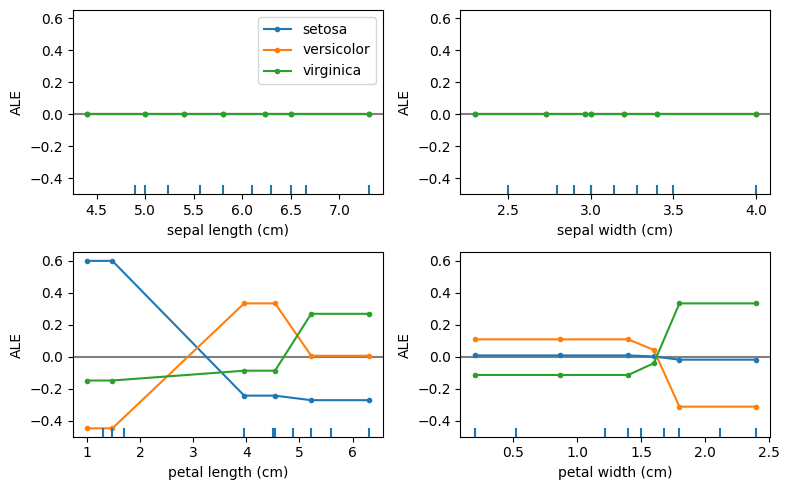

In [22]:
# now, we can provide the explanation results to the plot_ale function
# we can also specify the number of columns and control some figure parameters
plot_ale(exp, n_cols=2, fig_kw={'figwidth': 8, 'figheight': 5});


 - There are four subplots, one for each of the four features used as inputs to the model (sepal length, sepal width, petal length, petal width).
 
 - The ALE plots show how the predicted probability for each of the 3 iris classes changes across the range of values for each feature. This is depicted within each subplot by the 3 ALE curves, one for each class: setosa in blue, versicolor in orange, and virginica in green. 
 
 - The X-axis shows the feature values while the Y-axis shows the change in predicted probability for that class  with respect to the mean feature effect. 

 - Since the probabilities for all classes must sum to 1, an increase in probability for one class implies a decrease in probability for the other classes. 

 - The mostly flat ALE curves for sepal length and sepal width indicate that the model does not use these features much in distinguishing between classes. This agrees with the PDP plots and feature importance measures. In contrast, petal length and petal width show larger fluctuations, indicating they are more important features for the model's predictions.

### ALE for the Random Forest model

#### Train a RF

In [108]:
rf = RandomForestClassifier(n_estimators=3,
                            max_depth=2,
                            random_state=42)

rf.fit(X_train.values, y_train.values)

RandomForestClassifier(max_depth=2, n_estimators=3, random_state=42)

In [110]:
# random forest accuracy
accuracy_score(y_test, rf.predict(X_test.values))

0.9333333333333333

In [115]:
# random forest Feature Importance
pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)          

petal width (cm)     0.644792
petal length (cm)    0.352108
sepal length (cm)    0.003101
sepal width (cm)     0.000000
dtype: float64

#### ALE Plots

In [116]:
# create ALE explainer
ale_rf = ALE(
    predictor=rf.predict_proba,
    feature_names=feature_names,
    target_names=target_names,
)

# compute the ALE values
# the explain function expects a numpy array
exp_rf = ale_rf.explain(X_test.values)

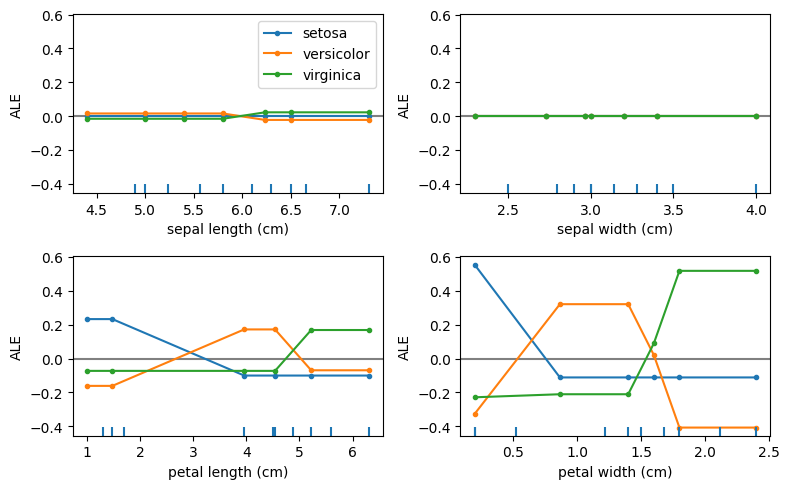

In [117]:
plot_ale(exp_rf, n_cols=2, fig_kw={'figwidth': 8, 'figheight': 5});


 - Both the xgboost and random forest models show a similar pattern where they didn't consider the sepal width feature, as indicated by the flat ALE curve around zero in the top right subplot. This observation aligns with the zero importance score for this feature from the Random Forest Feature Importance.

 - When looking at the sepal length feature, we notice a subtle difference between random forest and xgboost. The random forest model sees the sepal length as slightly useful, evidenced by small fluctuations in the ALE curves in the top left subplot. On the other hand, xgboost doesn't seem to find the sepal length as impactful. This insight helps us understand how each model values and utilizes this specific feature.
 

 - Now, to make the contrast between models regarding the sepal length more evident, we'll proceed by plotting the ALE for this particular feature from both the xgboost and random forest models, focusing on a specific target class. 

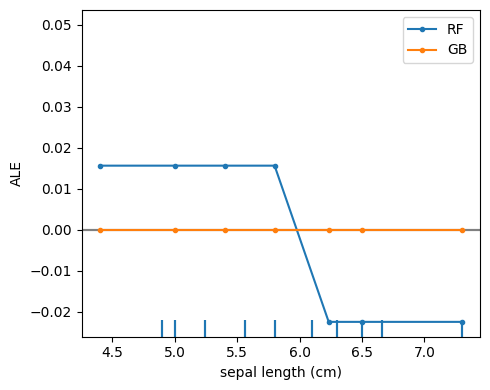

In [138]:

fig, ax = plt.subplots(1, 1, figsize=(5, 4),);

target_class = 'versicolor'
plot_ale(exp_rf, features=[0], targets=[target_class,], ax=ax, line_kw={'label': 'RF'});
plot_ale(exp, features=[0], targets=[target_class,], ax=ax, line_kw={'label': 'GB'});

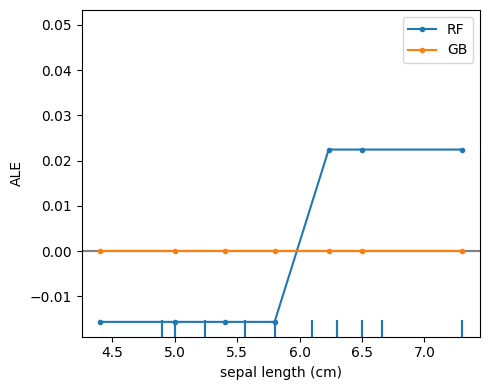

In [140]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4),);

target_class = 'virginica'
plot_ale(exp_rf, features=[0], targets=[target_class,], ax=ax, line_kw={'label': 'RF'});
plot_ale(exp, features=[0], targets=[target_class,], ax=ax, line_kw={'label': 'GB'});